## 一、背景
电子邮件是互联网的一项重要服务，在大家的学习、工作和生活中会广泛使用。但是大家的邮箱常常被各种各样的垃圾邮件填充了。有统计显示，每天互联网上产生的垃圾邮件有几百亿近千亿的量级。因此，对电子邮件服务提供商来说，垃圾邮件过滤是一项重要功能。而朴素贝叶斯算法在垃圾邮件识别任务上一直表现非常好，至今仍然有很多系统在使用朴素贝叶斯算法作为基本的垃圾邮件识别算法。

本次实验数据集来自[Trec06](https://plg.uwaterloo.ca/cgi-bin/cgiwrap/gvcormac/foo06)的中文垃圾邮件数据集，目录解压后包含三个文件夹，其中data目录下是所有的邮件（未分词），已分词好的邮件在data_cut目录下。邮件分为邮件头部分和正文部分，两部分之间一般有空行隔开。标签数据在label文件夹下，文件中每行是标签和对应的邮件路径。‘spam’表示垃圾邮件，‘ham’表示正常邮件。

## 二、任务
提取正文部分的文本特征，划分训练集和测试集，对比特征数目（词表大小）对模型效果的影响；尝试自行实现朴素贝叶斯算法细节；对比不同的概率计算方法。


## 三、评价指标
使用朴素贝叶斯算法完成垃圾邮件的分类与预测，要求测试集准确率Accuracy、精准率Precision、召回率Recall均高于0.9。


## 四、模型训练

* 本次实验数据集来自Trec06的中文垃圾邮件数据集，目录解压后包含三个文件夹，其中data目录下是所有的邮件（未分词），已分词好的邮件在data_cut目录下。邮件分为邮件头部分和正文部分，两部分之间一般有空行隔开。标签数据在label文件夹下，文件中每行是标签和对应的邮件路径。‘spam’表示垃圾邮件，‘ham’表示正常邮件。  
* 识别垃圾邮件已经很很多前人的经验：需要大样本的训练集，我们已经具备；不能忽略邮件头，我们打算对加不加入邮件头作个对比；只使用最显著的少数的词，我们打算对比词表大小对结果的影响。  
* 模型差异主要来自于特征的提取方式不同和分布时的所做的假设不同。提取方式考虑CountVectorizer和TfidfVectorizer；所做的假设不同考虑多项式朴素贝叶斯分类器（MultinomialNB）, 伯努利朴素贝叶斯分类器（BernoulliNB), 补码朴素贝叶斯分类器（ComplementNB)，高斯贝叶斯分类器（GaussianNB）。
* 针对垃圾邮件识别，假阳性的代价远高于假阴性。因此，模型评价上，在accuracy和recall满足“大于0.9”的基础上，我们选择优先选择precision最好的值。再考虑其它参数。


### 4.1、导入工具包

In [1]:
'''
提示：
若调用已有工具包，sklearn中提供了一些可能会用到的类。
'''
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer                # 提取文本特征向量的类
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB, GaussianNB        # 四种朴素贝叶斯算法，差别在于估计p(x|y)的方式
from sklearn.model_selection import train_test_split, cross_validate                        # 划分数据集函数
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score         # 模型评价
import re, base64, jieba                                                                    # 正则，编码，分词，词云
from wordcloud import WordCloud                                                             # 词云
import pandas as pd                                                                         # 数据处理
import matplotlib.pyplot as plt                                                             # 绘图
RANDOM_SEED = 100                                                                           # 固定随机种子

### 4.2、数据集读取、处理和划分

label/index文件含标签信息、对应样本文件的路径。路径信息中含的是未分区文件路径（data文件夹），处理成分词文件的路径（data_cut文件夹）后，直接用分好词的文件。样本是邮件，包含邮件头和邮件内容。邮件头读取Received、From、Reply-To、To和Subject的内容，并对内容作必要的解码和分词，再把处理好的邮件头的信息合并到分好词的内容中。

In [2]:
## 方法：提取邮件头信息，并进行必要的解码和分词
def filterEmailHeader(email_subject):
    header = '';
    ##取Received：
    p = re.compile(r'(?<=Received: from )[^/(|/[]*')
    matchObj_r = ' '.join(re.findall(p, email_subject))
    header += matchObj_r

    ##取Received：里的IP
    p = re.compile(r'(?<=\(\[)\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}')
    matchObj_ip = ' '.join(re.findall(p, email_subject))
    header += ' ' + matchObj_ip

    ##取<>里的内容，有可能是邮件地址，或Message-ID
    p = re.compile(r'(?<=\<)[^\>]*')
    matchObj_mid = ' '.join(re.findall(p, email_subject))
    header += ' ' + matchObj_mid

    ##取From:
    p = re.compile(r'(?<=From:)[^\<]*')
    matchObj_from = ' '.join(re.findall(p, email_subject))
    matchObj_from = matchObj_from.replace('"','').strip(' ')
    ##base64 + GB2312解码
    if matchObj_from.find('=?GB2312?B?')>= 0:
        matchObj_from = matchObj_from[(matchObj_from.find('=?GB2312?B?')+11):(len(matchObj_from)-2)]
        try:
            matchObj_from = base64.b64decode(matchObj_from).decode('GB2312')
        except :
            matchObj_from = ''
    header += ' ' + matchObj_from

    ##取 Reply-To:
    p = re.compile(r'(?<=Reply-To: )[^/<|"|\n]*')
    matchObj_reply =' '.join(re.findall(p, email_subject))
    header += ' ' + matchObj_reply

    ##取 To:
    p = re.compile(r'(?<=To: )[^/<|"|\n]*')
    matchObj_to =' '.join(re.findall(p, email_subject))
    header += ' ' + matchObj_to


    ##取 Subject:
    p = re.compile(r'(?<=Subject: )[^\<]*')
    matchObj_subject = ' '.join(re.findall(p, email_subject))
    matchObj_subject = matchObj_subject.replace('"','').strip(' ')
    ##base64 + GB2312解码
    if matchObj_subject.find('=?GB2312?B?') >= 0 or matchObj_subject.find('=?gb2312?B?') >= 0:
        matchObj_subject = matchObj_subject[11:(len(matchObj_subject)-2)]
        try:
            matchObj_subject = base64.b64decode(matchObj_subject).decode('GB2312')
            if len(matchObj_subject)>0 :
                jieba.suggest_freq(("代开", "发票"), True)
                jieba.suggest_freq(("代", "开发票"), True)
                matchObj_subject= ' '.join(jieba.cut(matchObj_subject))
        except :
            matchObj_subject = ''
    header += ' ' + matchObj_subject
    header = header.replace('com','').replace('cn','').replace('@',' ')
    return header

## 方法：读取邮件内容
def readEmail(src):
    src = src.replace('data', 'data_cut').replace('..', '.')
    with open(src, "r", encoding='utf-8', errors='ignore') as fp:
        email = fp.read()
        email_subject = email[:email.index('\n\n')]                                                 # 第一行空行作为邮件头和内容分离的标识
        email_content = email[email.index('\n\n') + 2:]
    return email_subject, email_content


label_df = pd.read_csv('./label/index', delim_whitespace=True, header=None, names=['spam', 'src'])  # 读入 csv 文件为 pandas 的 DataFrame
label, subject, content = [], [], []                                                                # 输出标签、提取的邮件头、提取的邮件内容

for x in range(len(label_df)):
    label_x = 1 if label_df['spam'][x] == 'spam' else 0
    label.append(label_x)
    subject_x, content_x = readEmail(label_df['src'][x])
    subject_x = filterEmailHeader(subject_x)
    subject.append(subject_x)
    # content.append(content_x)                                                                     # 提取的邮件内容只包含正文
    content.append(content_x + ' ' + subject_x)                                                     # 提取的邮件内容包含正文和处理过的邮件头

x_train, x_test, y_train, y_test = train_test_split(content, label, test_size=0.2,
                                                    random_state=RANDOM_SEED)                       # 将数据分为训练集与测试集

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 1.344 seconds.
Prefix dict has been built successfully.


## 五、模型构建

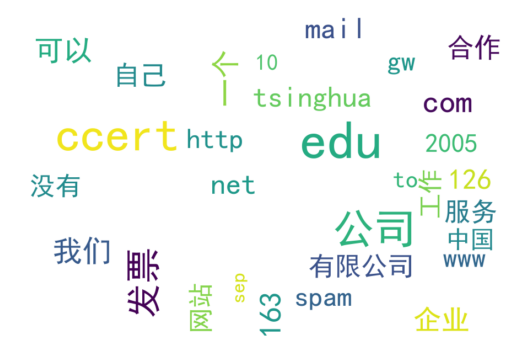

accuracy 0.9438254410399257  precision 0.9395359214636323  recall 0.9786195677434348  F1 0.9586795674445078


In [3]:
## 方法：绘制可视化词云
def draw_cloud(features_train, features_name, limits_count=30):
    df = pd.DataFrame(features_train, columns=features_name)
    df.describe()
    word_counts = dict(df.mean())
    # 绘制词云
    my_cloud = WordCloud(
        background_color='white',                                                                   # 设置背景颜色  默认是black
        width=900, height=600,
        max_words=limits_count,                                                                     # 词云显示的最大词语数量
        font_path='simhei.ttf',                                                                     # 设置字体  显示中文
        max_font_size=99,                                                                           # 设置字体最大值
        min_font_size=16,                                                                           # 设置子图最小值
        random_state=limits_count if limits_count<=100 else 100                                     # 设置随机生成词云的颜色，最多100种
    ).generate_from_frequencies(word_counts)

    plt.imshow(my_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

## 绘制可视化词云，方便观察特征
vectorizer = TfidfVectorizer(min_df=0.1, max_df=1.0, max_features=30)
cv_model = vectorizer.fit(x_train)
features_name = cv_model.get_feature_names_out()
features_train = cv_model.transform(x_train).toarray()
features_test = cv_model.transform(x_test).toarray()

draw_cloud(features_train, features_name)

## 先用 MultinomialNB 查看结果
model = MultinomialNB(alpha=1)
model.fit(features_train, y_train)
y_pred = model.predict(features_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred)
print('accuracy ' + str(accuracy) + '  precision ' + str(precision) + '  recall ' + str(recall) + '  F1 ' + str(F1))

### 六、模型对比和参数调优

模型差异主要来自于特征的提取方式不同和分布时的所做的假设不同。提取方式考虑CountVectorizer和TfidfVectorizer；所做的假设不同考虑多项式朴素贝叶斯分类器（MultinomialNB）, 伯努利朴素贝叶斯分类器（BernoulliNB), 补码朴素贝叶斯分类器（ComplementNB)，高斯贝叶斯分类器（GaussianNB）。下面是粗略的一个对比：

词云：CountVectorizer  max_features:10


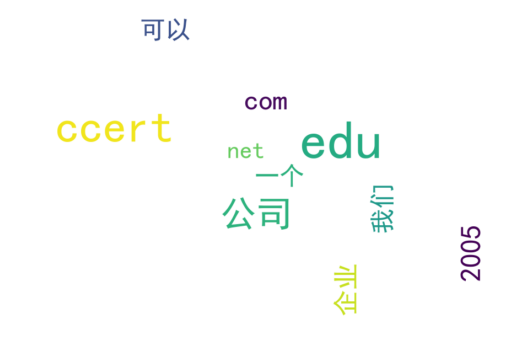

词云：TfidfVectorizer  max_features:10


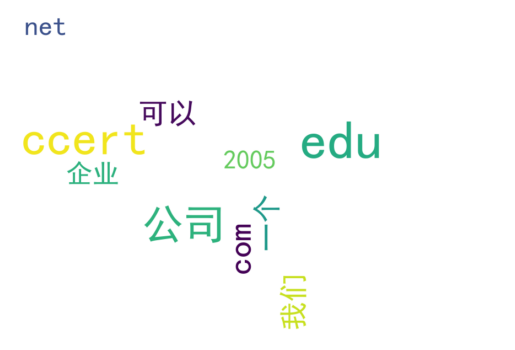

词云：CountVectorizer  max_features:20


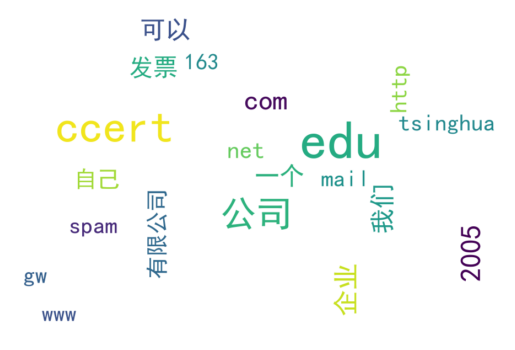

词云：TfidfVectorizer  max_features:20


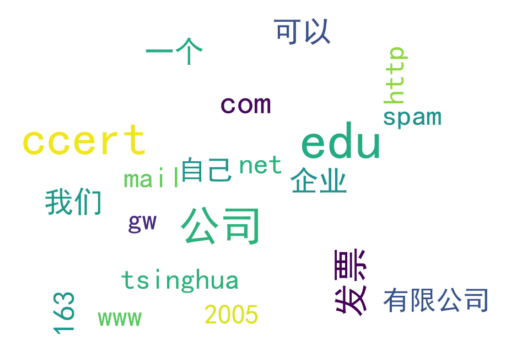

词云：CountVectorizer  max_features:30


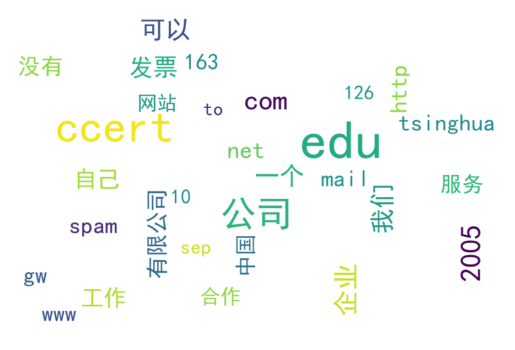

词云：TfidfVectorizer  max_features:30


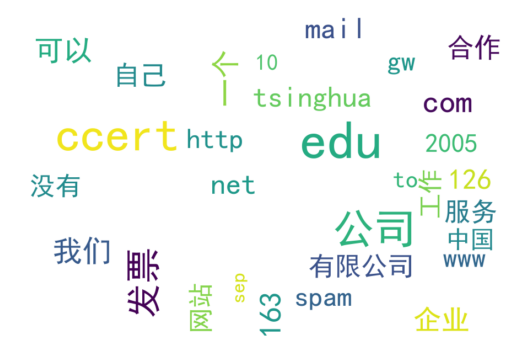

词云：CountVectorizer  max_features:40


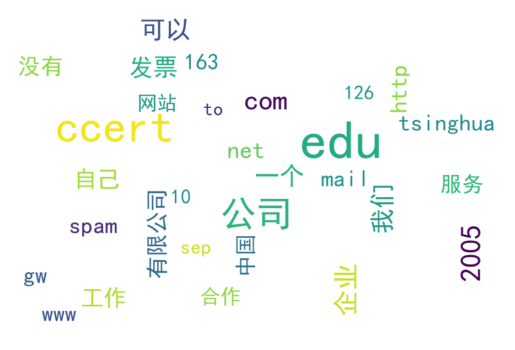

词云：TfidfVectorizer  max_features:40


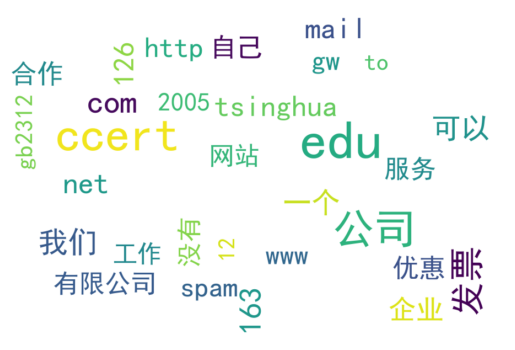

词云：CountVectorizer  max_features:50


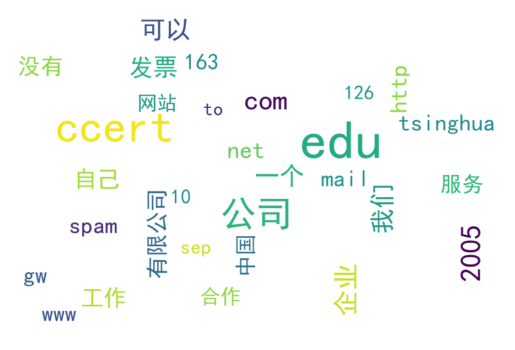

词云：TfidfVectorizer  max_features:50


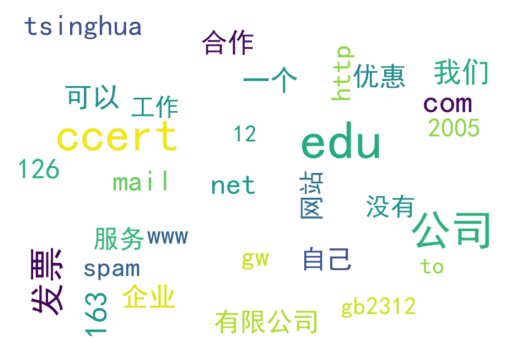

词云：CountVectorizer  max_features:60


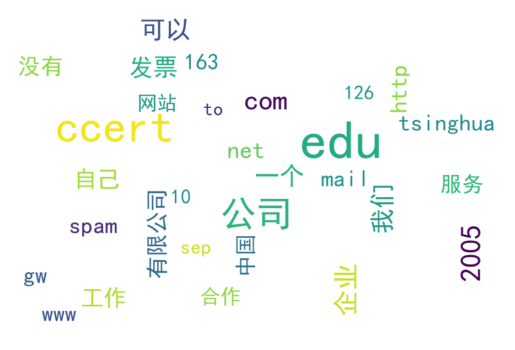

词云：TfidfVectorizer  max_features:60


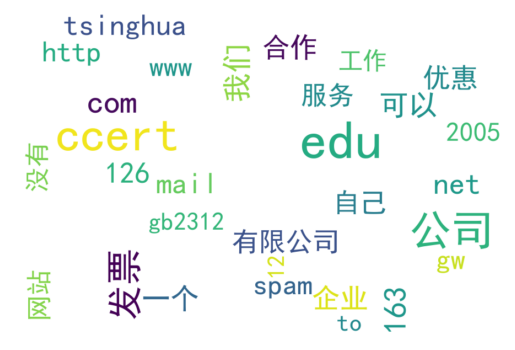

词云：CountVectorizer  max_features:70


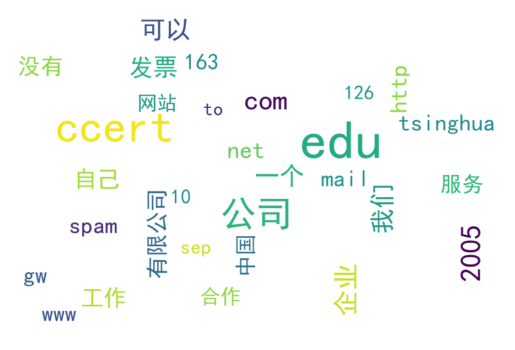

词云：TfidfVectorizer  max_features:70


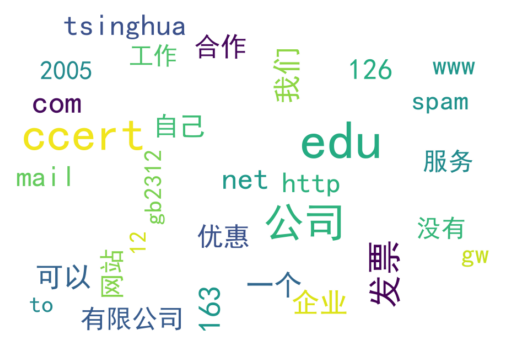

词云：CountVectorizer  max_features:80


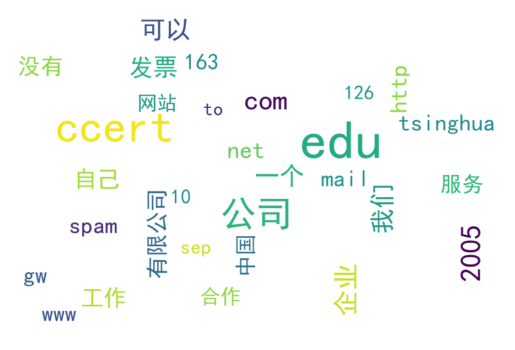

词云：TfidfVectorizer  max_features:80


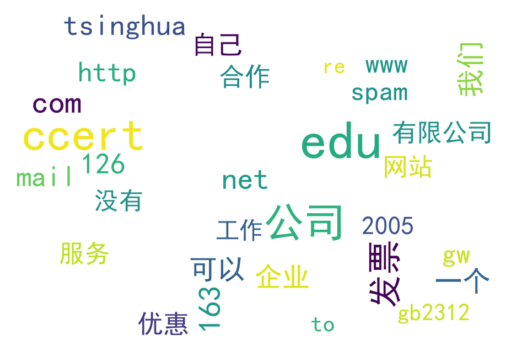

词云：CountVectorizer  max_features:90


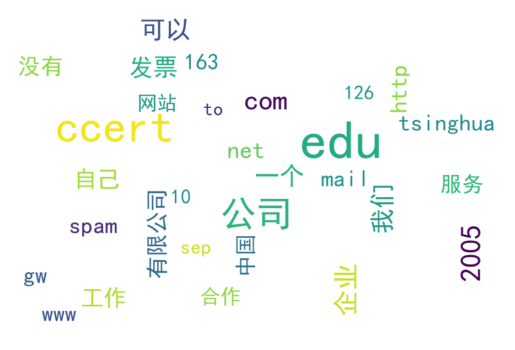

词云：TfidfVectorizer  max_features:90


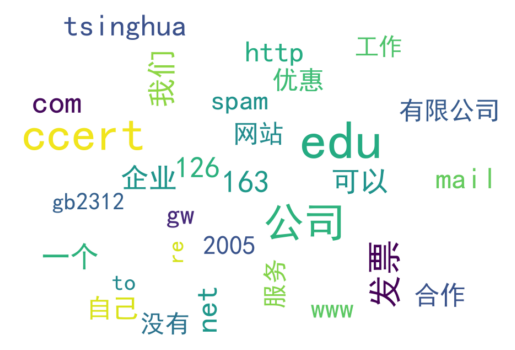

词云：CountVectorizer  max_features:100


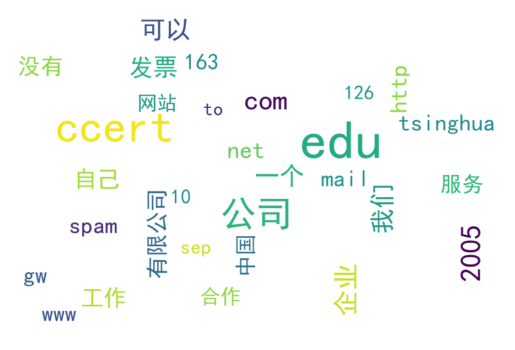

词云：TfidfVectorizer  max_features:100


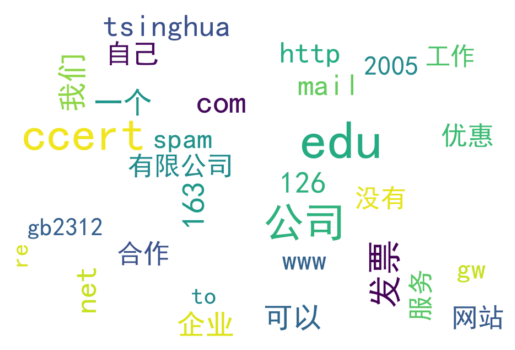

词云：CountVectorizer  max_features:150


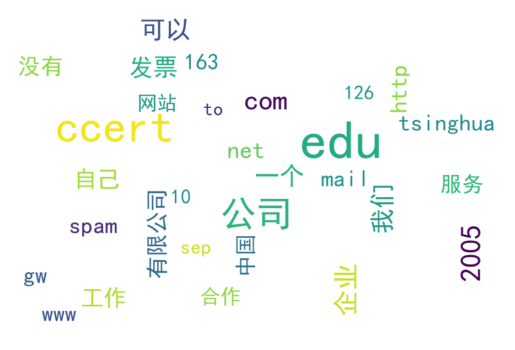

词云：TfidfVectorizer  max_features:150


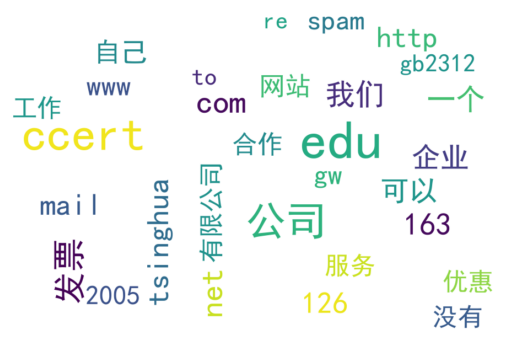

词云：CountVectorizer  max_features:200


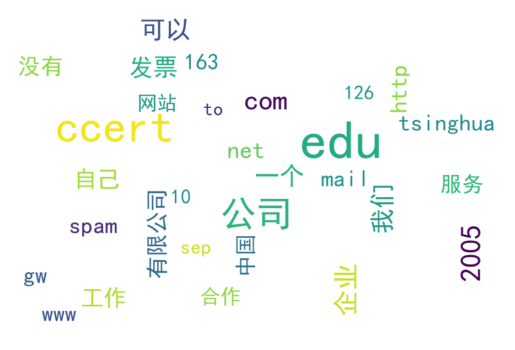

词云：TfidfVectorizer  max_features:200


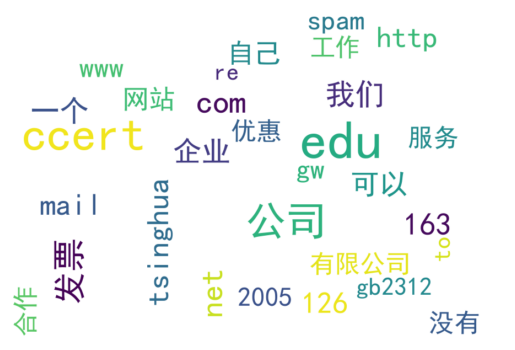

词云：CountVectorizer  max_features:250


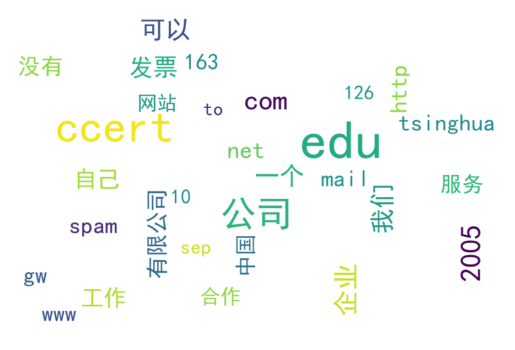

词云：TfidfVectorizer  max_features:250


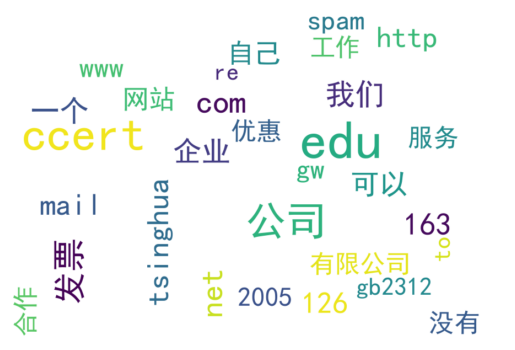

词云：CountVectorizer  max_features:300


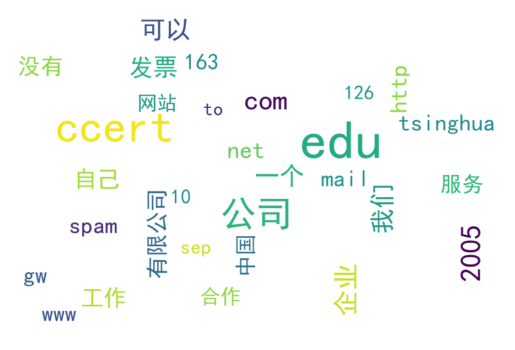

词云：TfidfVectorizer  max_features:300


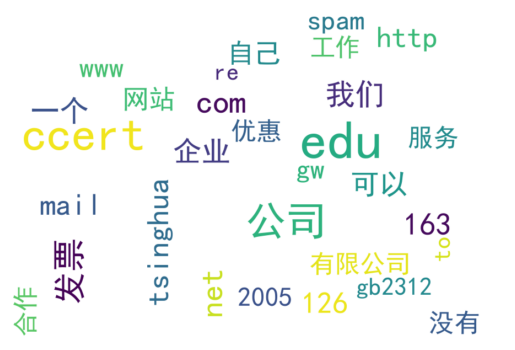

词云：CountVectorizer  max_features:400


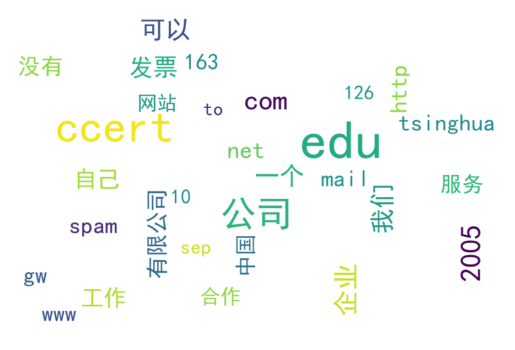

词云：TfidfVectorizer  max_features:400


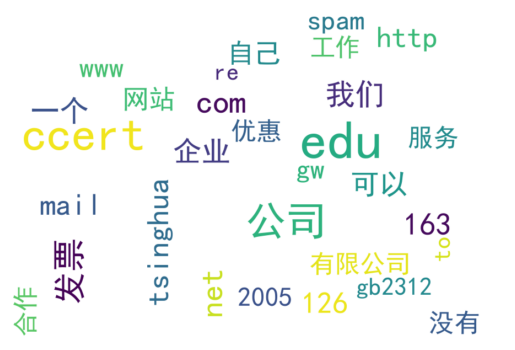

词云：CountVectorizer  max_features:500


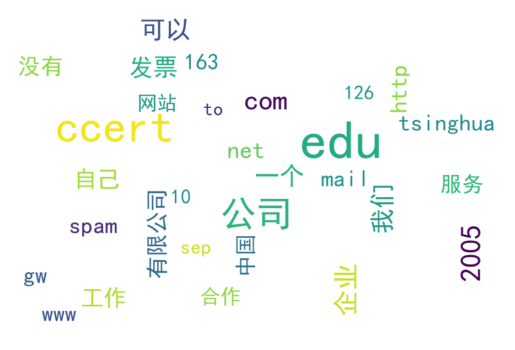

词云：TfidfVectorizer  max_features:500


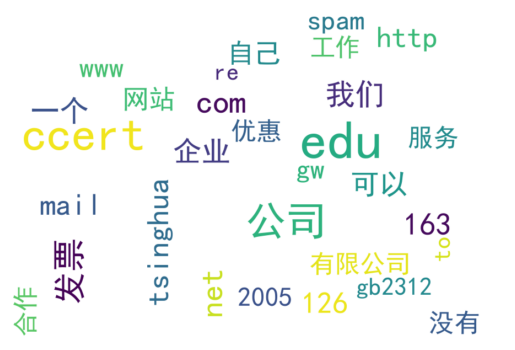

词云：CountVectorizer  max_features:1000


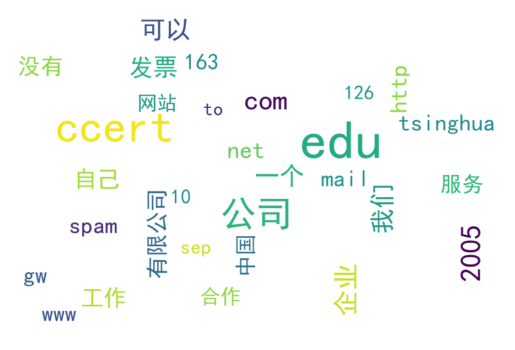

词云：TfidfVectorizer  max_features:1000


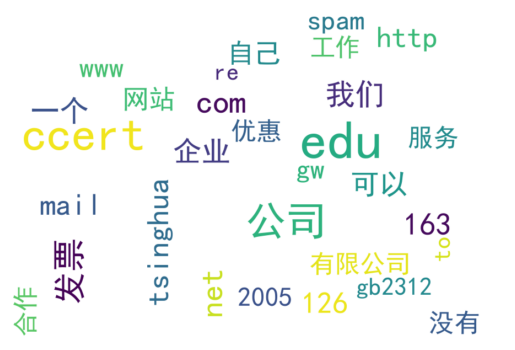

       model_names vectorizer_names  max_features  accuracys  precisions  \
0    MultinomialNB  CountVectorizer            10   0.894383    0.958233   
1      BernoulliNB  CountVectorizer            10   0.899102    0.946879   
2     ComplementNB  CountVectorizer            10   0.888347    0.965432   
3       GaussianNB  CountVectorizer            10   0.909548    0.903264   
4    MultinomialNB  TfidfVectorizer            10   0.868771    0.865222   
..             ...              ...           ...        ...         ...   
131     GaussianNB  CountVectorizer          1000   0.824048    0.992686   
132  MultinomialNB  TfidfVectorizer          1000   0.955664    0.976171   
133    BernoulliNB  TfidfVectorizer          1000   0.919375    0.991935   
134   ComplementNB  TfidfVectorizer          1000   0.947539    0.983061   
135     GaussianNB  TfidfVectorizer          1000   0.914578    0.988157   

      recalls        F1  
0    0.879735  0.917308  
1    0.898908  0.922270  
2    0.86

In [5]:
exec_reult = pd.DataFrame(columns=['model_names','vectorizer_names','max_features','accuracys','precisions','recalls','F1'])   # 记录模型参数和评价
max_features  = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 400, 500, 1000]
for max_feature in max_features: 
    for vectorizer_name, vectorizer in zip(['CountVectorizer', 'TfidfVectorizer'], 
                                            [CountVectorizer(min_df=0.1, max_df=1.0, max_features=max_feature), 
                                            TfidfVectorizer(min_df=0.1, max_df=1.0, max_features=max_feature)]):        # vectorizer
        cv_model = vectorizer.fit(x_train)
        features_name = cv_model.get_feature_names_out()
        features_train = cv_model.transform(x_train).toarray()
        features_test = cv_model.transform(x_test).toarray()        
        for model_name, model in zip(['MultinomialNB', 'BernoulliNB', 'ComplementNB', 'GaussianNB'], [MultinomialNB(), BernoulliNB(), ComplementNB(), GaussianNB()]):
            model.fit(features_train, y_train)
            y_pred = model.predict(features_test)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            F1 = f1_score(y_test, y_pred)

            # print('model_name ' + model_name + '  vectorizer_name ' + vectorizer_name + '  max_features ' + str(max_features) +'  accuracy ' + str(accuracy) + '  precision ' + str(precision) + '  recall ' + str(recall))
            exec_reult.loc[exec_reult.shape[0]]=[model_name, vectorizer_name, max_feature, accuracy, precision, recall,F1]
            # exec_reult = pd.concat([exec_reult, pd.Series({'model_names': model_name,'vectorizer_names': vectorizer_name,'max_features': max_feature,
            #                         'accuracys': accuracy,'precisions': precision,'recalls': recall})])
        
        print('词云：'+vectorizer_name + '  max_features:' + str(max_feature))                                            # 汇制词云
        draw_cloud(features_train, features_name)
print(exec_reult)                                                                                                          #查看执行结果
exec_reult.to_csv("reult.csv",index=False)


不同个数特征带来的影响：随着特征数的增多，准确率呈现在各个不同的分类器上表现出不同的特征：
* 多项式朴素贝叶斯分类器（MultinomialNB）和 补码朴素贝叶斯分类器（ComplementNB) 准确率呈现先上升后下降，到200时基本平稳。
* 伯努利朴素贝叶斯分类器（BernoulliNB) 和 高斯贝叶斯分类器（GaussianNB） 准确率呈现先上升后下降的趋势。

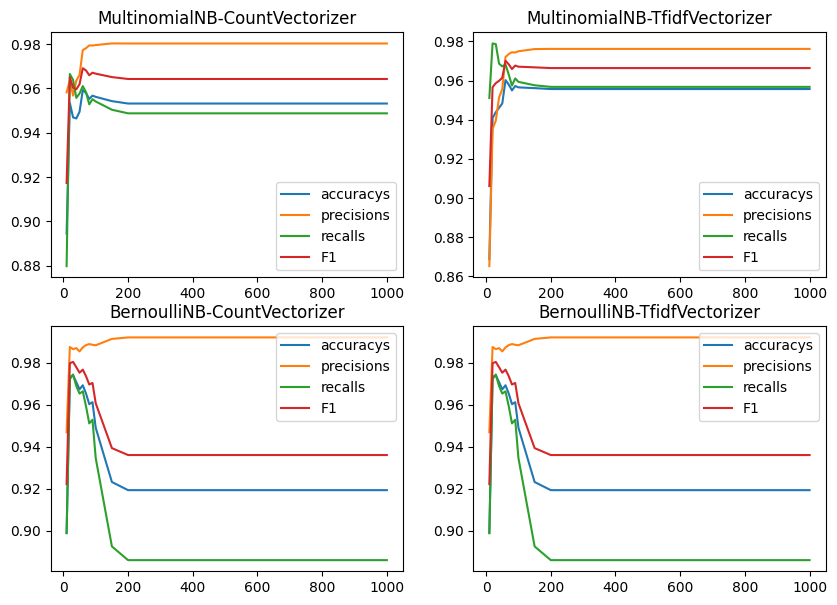

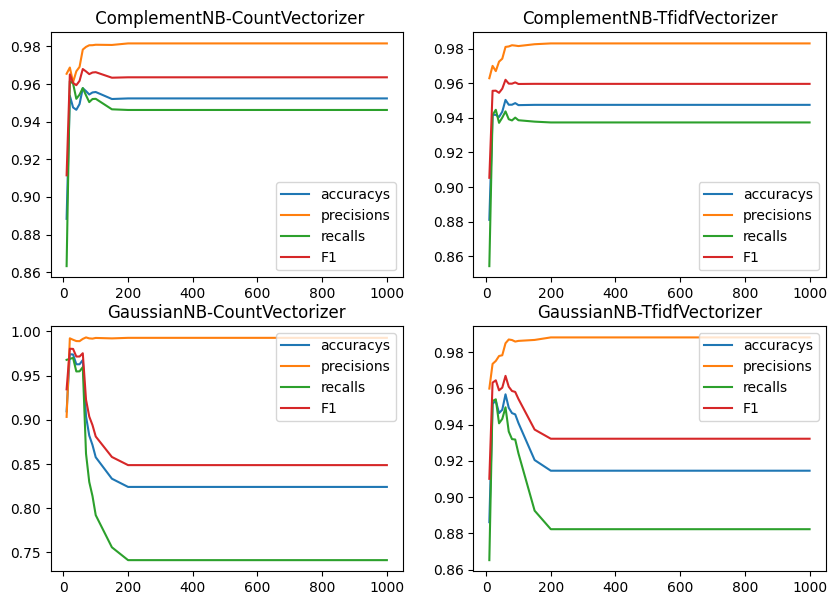

In [156]:

plt.figure(figsize=(10, 7), dpi=100)
exec_reult_MultinomialNB = exec_reult.query("model_names == 'MultinomialNB' & vectorizer_names == 'CountVectorizer' ")
ax1 = plt.subplot(221)
ax1.plot(exec_reult_MultinomialNB['max_features'].values.tolist(), exec_reult_MultinomialNB['accuracys'].values.tolist(), label='accuracys')
ax1.plot(exec_reult_MultinomialNB['max_features'].values.tolist(), exec_reult_MultinomialNB['precisions'].values.tolist(), label='precisions')
ax1.plot(exec_reult_MultinomialNB['max_features'].values.tolist(), exec_reult_MultinomialNB['recalls'].values.tolist(), label='recalls')
ax1.plot(exec_reult_MultinomialNB['max_features'].values.tolist(), exec_reult_MultinomialNB['F1'].values.tolist(), label='F1')
ax1.set_title('MultinomialNB-CountVectorizer')
ax1.legend()

exec_reult_MultinomialNB = exec_reult.query("model_names == 'MultinomialNB' & vectorizer_names == 'TfidfVectorizer' ")
ax2 = plt.subplot(222)
ax2.plot(exec_reult_MultinomialNB['max_features'].values.tolist(), exec_reult_MultinomialNB['accuracys'].values.tolist(), label='accuracys')
ax2.plot(exec_reult_MultinomialNB['max_features'].values.tolist(), exec_reult_MultinomialNB['precisions'].values.tolist(), label='precisions')
ax2.plot(exec_reult_MultinomialNB['max_features'].values.tolist(), exec_reult_MultinomialNB['recalls'].values.tolist(), label='recalls')
ax2.plot(exec_reult_MultinomialNB['max_features'].values.tolist(), exec_reult_MultinomialNB['F1'].values.tolist(), label='F1')
ax2.set_title('MultinomialNB-TfidfVectorizer')
ax2.legend()

exec_reult_BernoulliNB = exec_reult.query("model_names == 'BernoulliNB' & vectorizer_names == 'CountVectorizer' ")
ax3 = plt.subplot(223)
ax3.plot(exec_reult_BernoulliNB['max_features'].values.tolist(), exec_reult_BernoulliNB['accuracys'].values.tolist(), label='accuracys')
ax3.plot(exec_reult_BernoulliNB['max_features'].values.tolist(), exec_reult_BernoulliNB['precisions'].values.tolist(), label='precisions')
ax3.plot(exec_reult_BernoulliNB['max_features'].values.tolist(), exec_reult_BernoulliNB['recalls'].values.tolist(), label='recalls')
ax3.plot(exec_reult_BernoulliNB['max_features'].values.tolist(), exec_reult_BernoulliNB['F1'].values.tolist(), label='F1')
ax3.set_title('BernoulliNB-CountVectorizer')
ax3.legend()

exec_reult_BernoulliNB = exec_reult.query("model_names == 'BernoulliNB' & vectorizer_names == 'TfidfVectorizer' ")
ax4 = plt.subplot(224)
ax4.plot(exec_reult_BernoulliNB['max_features'].values.tolist(), exec_reult_BernoulliNB['accuracys'].values.tolist(), label='accuracys')
ax4.plot(exec_reult_BernoulliNB['max_features'].values.tolist(), exec_reult_BernoulliNB['precisions'].values.tolist(), label='precisions')
ax4.plot(exec_reult_BernoulliNB['max_features'].values.tolist(), exec_reult_BernoulliNB['recalls'].values.tolist(), label='recalls')
ax4.plot(exec_reult_BernoulliNB['max_features'].values.tolist(), exec_reult_BernoulliNB['F1'].values.tolist(), label='F1')
ax4.set_title('BernoulliNB-TfidfVectorizer')
ax4.legend()

plt.figure(figsize=(10, 7), dpi=100)
exec_reult_ComplementNB = exec_reult.query("model_names == 'ComplementNB' & vectorizer_names == 'CountVectorizer' ")
ax5 = plt.subplot(221)
ax5.plot(exec_reult_ComplementNB['max_features'].values.tolist(), exec_reult_ComplementNB['accuracys'].values.tolist(), label='accuracys')
ax5.plot(exec_reult_ComplementNB['max_features'].values.tolist(), exec_reult_ComplementNB['precisions'].values.tolist(), label='precisions')
ax5.plot(exec_reult_ComplementNB['max_features'].values.tolist(), exec_reult_ComplementNB['recalls'].values.tolist(), label='recalls')
ax5.plot(exec_reult_ComplementNB['max_features'].values.tolist(), exec_reult_ComplementNB['F1'].values.tolist(), label='F1')
ax5.set_title(' ComplementNB-CountVectorizer')
ax5.legend()

ax6 = plt.subplot(222)
exec_reult_ComplementNB = exec_reult.query("model_names == 'ComplementNB' & vectorizer_names == 'TfidfVectorizer' ")
ax6.plot(exec_reult_ComplementNB['max_features'].values.tolist(), exec_reult_ComplementNB['accuracys'].values.tolist(), label='accuracys')
ax6.plot(exec_reult_ComplementNB['max_features'].values.tolist(), exec_reult_ComplementNB['precisions'].values.tolist(), label='precisions')
ax6.plot(exec_reult_ComplementNB['max_features'].values.tolist(), exec_reult_ComplementNB['recalls'].values.tolist(), label='recalls')
ax6.plot(exec_reult_ComplementNB['max_features'].values.tolist(), exec_reult_ComplementNB['F1'].values.tolist(), label='F1')
ax6.set_title('ComplementNB-TfidfVectorizer')
ax6.legend()

exec_reult_GaussianNB = exec_reult.query("model_names == 'GaussianNB' & vectorizer_names == 'CountVectorizer' ")
ax7 = plt.subplot(223)
ax7.plot(exec_reult_GaussianNB['max_features'].values.tolist(), exec_reult_GaussianNB['accuracys'].values.tolist(), label='accuracys')
ax7.plot(exec_reult_GaussianNB['max_features'].values.tolist(), exec_reult_GaussianNB['precisions'].values.tolist(), label='precisions')
ax7.plot(exec_reult_GaussianNB['max_features'].values.tolist(), exec_reult_GaussianNB['recalls'].values.tolist(), label='recalls')
ax7.plot(exec_reult_GaussianNB['max_features'].values.tolist(), exec_reult_GaussianNB['F1'].values.tolist(), label='F1')
ax7.set_title('GaussianNB-CountVectorizer')
ax7.legend()

exec_reult_GaussianNB = exec_reult.query("model_names == 'GaussianNB' & vectorizer_names == 'TfidfVectorizer' ")
ax8 = plt.subplot(224)
ax8.plot(exec_reult_GaussianNB['max_features'].values.tolist(), exec_reult_GaussianNB['accuracys'].values.tolist(), label='accuracys')
ax8.plot(exec_reult_GaussianNB['max_features'].values.tolist(), exec_reult_GaussianNB['precisions'].values.tolist(), label='precisions')
ax8.plot(exec_reult_GaussianNB['max_features'].values.tolist(), exec_reult_GaussianNB['recalls'].values.tolist(), label='recalls')
ax8.plot(exec_reult_GaussianNB['max_features'].values.tolist(), exec_reult_GaussianNB['F1'].values.tolist(), label='F1')
ax8.set_title('GaussianNB-TfidfVectorizer')
ax8.legend()

在accuracy和recall满足“大于0.9”的基础上，我们选择优先选择precision**最好的模型为：GaussianNB，采用CountVectorizer，最大20个特征词。 模型评价：accuracy为0.974156608；precision为0.992146597；recall为0.968858936**。 

In [15]:
grouped = exec_reult.query('accuracys >= 0.9 & precisions >= 0.9 & recalls >=0.9')['precisions'].idxmax()
print(exec_reult.loc[grouped])

model_names              GaussianNB
vectorizer_names    CountVectorizer
max_features                     20
accuracys                  0.974157
precisions                 0.992147
recalls                    0.968859
F1                         0.980364
Name: 11, dtype: object


上面最优的结果，是提取了邮件头的特征。如果不考虑邮件头，只采用邮件内容的特征，同样使用GaussianNB，采用CountVectorizer，最大20个特征词。 模型评价：accuracy为0.8163107397；precision为0.9811612106；recall为0.7383221008，F1为0.84259382。不达标。只能使用其它分类器，如BernoulliNB。 

In [16]:
label_df = pd.read_csv('./label/index', delim_whitespace=True, header=None, names=['spam', 'src'])  # 读入 csv 文件为 pandas 的 DataFrame
label, subject, content = [], [], []                                                                # 输出标签、提取的邮件头、提取的邮件内容

for x in range(len(label_df)):
    label_x = 1 if label_df['spam'][x] == 'spam' else 0
    label.append(label_x)
    subject_x, content_x = readEmail(label_df['src'][x])
    subject_x = filterEmailHeader(subject_x)
    subject.append(subject_x)
    content.append(content_x)                                                                       # 提取的邮件内容只包含正文，不包含邮件头

x_train, x_test, y_train, y_test = train_test_split(content, label, test_size=0.2,
                                                    random_state=RANDOM_SEED)                       # 将数据分为训练集与测试集

vectorizer = CountVectorizer(min_df=0.1, max_df=1.0, max_features=20)
cv_model = vectorizer.fit(x_train)
features_name = cv_model.get_feature_names_out()
features_train = cv_model.transform(x_train).toarray()
features_test = cv_model.transform(x_test).toarray()

## 绘制可视化词云，方便观察特征
#draw_cloud(features_train, features_name)

In [17]:
## MultinomialNB 分类器
model = MultinomialNB()
model.fit(features_train, y_train)
y_pred = model.predict(features_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred)
print('不考虑邮件头特征的情况下MultinomialNB：accuracy ' + str(accuracy) + '  precision ' + str(precision) + '  recall ' + str(recall) + '  F1 ' + str(F1))

## BernoulliNB 分类器
model = BernoulliNB()
model.fit(features_train, y_train)
y_pred = model.predict(features_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred)
print('不考虑邮件头特征的情况下BernoulliNB：accuracy ' + str(accuracy) + '  precision ' + str(precision) + '  recall ' + str(recall) + '  F1 ' + str(F1))

## ComplementNB 分类器
model = ComplementNB()
model.fit(features_train, y_train)
y_pred = model.predict(features_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred)
print('不考虑邮件头特征的情况下ComplementNB：accuracy ' + str(accuracy) + '  precision ' + str(precision) + '  recall ' + str(recall) + '  F1 ' + str(F1))

## GaussianNB 分类器
model = GaussianNB()
model.fit(features_train, y_train)
y_pred = model.predict(features_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred)
print('不考虑邮件头特征的情况下GaussianNB：accuracy ' + str(accuracy) + '  precision ' + str(precision) + '  recall ' + str(recall) + '  F1 ' + str(F1))


不考虑邮件头特征的情况下MultinomialNB：accuracy 0.9007273290003095  precision 0.9115432168146567  recall 0.9423657913083895  F1 0.9266982802948067
不考虑邮件头特征的情况下BernoulliNB：accuracy 0.9268028474156608  precision 0.9663906478324403  recall 0.9221473390657681  F1 0.9437507432512784
不考虑邮件头特征的情况下ComplementNB：accuracy 0.9098576292169607  precision 0.9606289463909867  recall 0.9015802928189636  F1 0.930168434933765
不考虑邮件头特征的情况下GaussianNB：accuracy 0.8163107397090684  precision 0.9811612106238419  recall 0.7383221008598652  F1 0.8425938204482164


### 七、小结

本例中的模型，特征的提取方式不同和分布时的所做的假设不同。经过反复对比，有以下结论：
* 针对邮件识别，假阳性的代价远高于假阴性。因此，在accuracy和recall满足“大于0.9”的基础上，我们选择优先选择precision最好的值。MultinomialNB、BernoulliNB、ComplementNB、GaussianNB的最好precision值分别为0.980309761、0.992146597，0.983061175、0.988765402。我们认为**GaussianNB的效果最佳（采用CountVectorizer，最大20个特征词）。 模型评价：accuracy为0.974157；precision为0.992147；recall为0.968859；F1为0.980364**。 
* 邮件头的处理很重要。在“数据集读取、处理和划分”的提取的邮件内容包含正文和处理过的邮件头中，是否考虑邮件头，对不同分类器的accuracy、precision、recall最优值的影响都不一样，但考虑邮件头的情况下都有提升。
* 不同个数特征带来的影响：随着特征数的增多，准确率呈现在各个不同的分类器上表现出不同的特征： 多项式朴素贝叶斯分类器（MultinomialNB）和 补码朴素贝叶斯分类器（ComplementNB) 准确率呈现先上升后下降，到200时基本平稳；伯努利朴素贝叶斯分类器（BernoulliNB) 和 高斯贝叶斯分类器（GaussianNB） 准确率呈现先上升后下降的趋势。
